In [0]:
from __future__ import print_function,division,unicode_literals
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [0]:
tf.reset_default_graph()
np.random.seed(42)
tf.set_random_seed(42)

In [0]:
from google.colab import auth
auth.authenticate_user()

In [5]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpwfzus021/pubring.gpg' created
gpg: /tmp/tmpwfzus021/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p MyDrive
!google-drive-ocamlfuse MyDrive

In [0]:
mnist_path="/MyDrive/Datasets/MNIST"

In [0]:
from tensorflow.examples.tutorials.mnist import input_data

In [11]:
mnist=input_data.read_data_sets(mnist_path)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /MyDrive/Datasets/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /MyDrive/Datasets/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /MyDrive/Datasets/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /MyDrive/Datasets/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensor

# MNIST

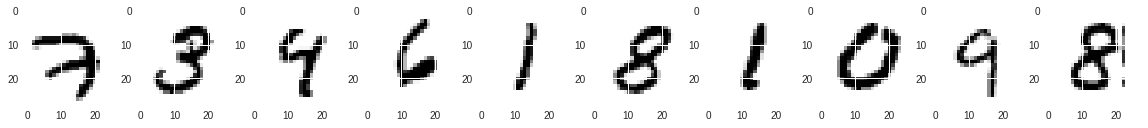

In [12]:
num_samples=10
plt.figure(figsize=(num_samples*2,3))
for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    sample_image = mnist.train.images[i].reshape(28,28)
    plt.imshow(sample_image,cmap='binary')
plt.show()

In [13]:
print(mnist.train.labels[:num_samples])

[7 3 4 6 1 8 1 0 9 8]


# Capsule Network

In [0]:
from IPython.display import Image,display

In [17]:
display(Image("./MyDrive/Images/capsule_model.jpg"))

In [0]:
image_size=28
x_images = tf.placeholder(shape=[None,image_size,image_size,1],dtype=tf.float32,name="x_images")

## Primary Capsule

In [0]:
capsule_primary_num_fmaps=32
capsule_primary_num_capsules=capsule_primary_num_fmaps*6*6 #32*6*6=1152
capsule_primary_num_dimentions=8

In [0]:
conv1_params={
    "filters":256,
    "kernel_size":9,
    "strides":1,
    "padding":"valid",
    "activation":tf.nn.relu
}
conv2_params={
    "filters":256,
    "kernel_size":9,
    "strides":2,
    "padding":"valid",
    "activation":tf.nn.relu
}

In [0]:
conv1_layer = tf.layers.conv2d(x_images,name="conv1_layer",**conv1_params)
conv2_layer = tf.layers.conv2d(conv1_layer,name="conv2_layer",**conv2_params)

In [0]:
primary_capsule_layer = tf.reshape(conv2_layer,[-1,capsule_primary_num_capsules,capsule_primary_num_dimentions],name="primary_capsule_layer")

## Squashing

In [0]:
def squash(s,axis=-1,epsilon=1e-7,name=None):
    with tf.name_scope(name,default_name="squash"):
        s_squared_norm = tf.reduce_sum(tf.square(s),axis=axis,keepdims=True)
        s_norm = tf.sqrt(s_squared_norm+epsilon)
        squash_factor=s_squared_norm/(1.0+s_squared_norm)
        unit_s = s/s_norm
        return squash_factor*unit_s

In [0]:
primary_capsule_output=squash(primary_capsule_layer,name="primary_capsule_output")

In [0]:
capsule_digit_num_capsules = 10
capsule_digit_num_dimentions=16

In [0]:
W_init_sigma = 0.1
W_tensor = tf.random_normal(shape=[1,capsule_primary_num_capsules, 
                                   capsule_digit_num_capsules,
                                   capsule_digit_num_dimentions,
                                   capsule_primary_num_dimentions
                                   ],
                            stddev=W_init_sigma,dtype=tf.float32,name="W_tensor")
W = tf.Variable(W_tensor,name="W")

In [0]:
batch_size = tf.shape(x_images)[0]
W_tiled = tf.tile(W,[batch_size,1,1,1,1],name="W_tiled")

In [0]:
primary_capsule_output_expand = tf.expand_dims(primary_capsule_output,axis=-1,name="primary_capsule_output_expand")

In [0]:
primary_capsule_output_expand_for_digit = tf.expand_dims(primary_capsule_output_expand,axis=2,name="primary_capsule_output_expand_for_digit")

In [0]:
primary_capsule_output_tiled_digit = tf.tile(primary_capsule_output_expand_for_digit,[1,1,capsule_digit_num_capsules,1,1],name="primary_capsule_output_tiled_digit")

In [31]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

In [32]:
primary_capsule_output_tiled_digit

<tf.Tensor 'primary_capsule_output_tiled_digit:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

In [0]:
primary_capsule_predicts=tf.matmul(W_tiled,primary_capsule_output_tiled_digit,name="primary_capsule_predicts")

In [34]:
primary_capsule_predicts

<tf.Tensor 'primary_capsule_predicts:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [0]:
b = tf.zeros(shape=[batch_size,capsule_primary_num_capsules,capsule_digit_num_capsules,1,1],name="b_weights",dtype=tf.float32)
c = tf.nn.softmax(b,axis=2,name="c_weights")

In [36]:
b

<tf.Tensor 'b_weights:0' shape=(?, 1152, 10, 1, 1) dtype=float32>

In [37]:
c

<tf.Tensor 'c_weights:0' shape=(?, 1152, 10, 1, 1) dtype=float32>

In [0]:
primary_capsule_weighted_predictes = tf.multiply(c,primary_capsule_predicts,name="primary_capsule_weighted_predictes")

In [39]:
primary_capsule_weighted_predictes

<tf.Tensor 'primary_capsule_weighted_predictes:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [0]:
digit_capsule_weighted_sum_input = tf.reduce_sum(primary_capsule_weighted_predictes,axis=1,keepdims=True,name="digit_capsule_weighted_sum_input")

In [41]:
digit_capsule_weighted_sum_input

<tf.Tensor 'digit_capsule_weighted_sum_input:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [0]:
digit_capsule_output_round1 = squash(digit_capsule_weighted_sum_input,axis=-2,name="digit_capsule_output_round1")

In [43]:
digit_capsule_output_round1

<tf.Tensor 'digit_capsule_output_round1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [0]:
digit_capsule_output_round1_tiled = tf.tile(digit_capsule_output_round1,[1,capsule_primary_num_capsules,1,1,1],name="digit_capsule_output_round1_tiled")

In [46]:
digit_capsule_output_round1_tiled

<tf.Tensor 'digit_capsule_output_round1_tiled:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [0]:
routing_agreement = tf.matmul(primary_capsule_predicts,digit_capsule_output_round1_tiled,transpose_a=True,name="routing_agreement")

In [48]:
routing_agreement

<tf.Tensor 'routing_agreement:0' shape=(?, 1152, 10, 1, 1) dtype=float32>

In [49]:
b

<tf.Tensor 'b_weights:0' shape=(?, 1152, 10, 1, 1) dtype=float32>

In [0]:
b_round2 = tf.add(b,routing_agreement,name="b_round2")

In [0]:
c_round2 = tf.nn.softmax(b_round2,axis=2,name="c_round2")

In [0]:
primary_capsule_weighted_predictes_round2 = tf.multiply(c_round2,primary_capsule_predicts,name="primary_capsule_weighted_predictes_round2")

In [0]:
digit_capsule_weighted_sum_input_round2 = tf.reduce_sum(primary_capsule_weighted_predictes_round2,axis=1,keepdims=True,
                                                        name="digit_capsule_weighted_sum_input_round2")

In [0]:
digit_capsule_output_round2 = squash(digit_capsule_weighted_sum_input_round2,axis=-2,name="digit_capsule_output_round2")

In [55]:
digit_capsule_output_round2

<tf.Tensor 'digit_capsule_output_round2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [56]:
primary_capsule_predicts

<tf.Tensor 'primary_capsule_predicts:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [0]:
digit_capsule_output_round2_tiled = tf.tile(digit_capsule_output_round2,[1,capsule_primary_num_capsules,1,1,1],name="digit_capsule_output_round2_tiled")
routing_agreement_2 = tf.matmul(primary_capsule_predicts,digit_capsule_output_round2_tiled,transpose_a=True,name="routing_agreement2")
b_round3 = tf.add(b_round2,routing_agreement_2,name="b_round3")
c_round3 = tf.nn.softmax(b_round3,axis=2,name="c_round3")
primary_capsule_weighted_predictes_round3 = tf.multiply(c_round3,primary_capsule_predicts,name="primary_capsule_weighted_predictes_round3")
digit_capsule_weighted_sum_input_round3 = tf.reduce_sum(primary_capsule_weighted_predictes_round3,axis=1,keepdims=True,
                                                        name="digit_capsule_weighted_sum_input_round3")
digit_capsule_output_round3 = squash(digit_capsule_weighted_sum_input_round3,axis=-2,name="digit_capsule_output_round3")

In [0]:
digit_capsule_output=digit_capsule_output_round3

In [59]:
digit_capsule_output

<tf.Tensor 'digit_capsule_output_round3/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [0]:
def safe_norm(s,axis=-1,epsilon=1e-7,name=None,keepdims=False):
    with tf.name_scope(name,default_name="safe_norm"):
        squred_sum = tf.reduce_sum(tf.square(s),axis=axis,keepdims=keepdims)
        s_safe_norm = tf.sqrt(squred_sum+epsilon)
        return s_safe_norm

In [0]:
y_pred_prob = safe_norm(digit_capsule_output,axis=-2,name="y_pred_prob")

In [62]:
y_pred_prob

<tf.Tensor 'y_pred_prob/Sqrt:0' shape=(?, 1, 10, 1) dtype=float32>

In [0]:
y_pred_argmax = tf.argmax(y_pred_prob,axis=2,name="y_pred_argmax")

In [64]:
y_pred_argmax

<tf.Tensor 'y_pred_argmax:0' shape=(?, 1, 1) dtype=int64>

In [0]:
y_pred = tf.squeeze(y_pred_argmax,axis=[1,2],name="y_pred")

In [66]:
y_pred

<tf.Tensor 'y_pred:0' shape=(?,) dtype=int64>

In [0]:
y_true = tf.placeholder(shape=[None],dtype=tf.int64,name="y_true")

## Margin Loss

In [0]:
m_plus = 0.9
m_minus = 0.1
lambda_l = 0.5

In [0]:
T = tf.one_hot(y_true,depth=capsule_digit_num_capsules,name="T")

In [70]:
digit_capsule_output

<tf.Tensor 'digit_capsule_output_round3/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [0]:
digit_capsule_output_norm = safe_norm(digit_capsule_output,axis=-2,name="digit_capsule_output_norm",keepdims=True)

In [72]:
digit_capsule_output_norm

<tf.Tensor 'digit_capsule_output_norm/Sqrt:0' shape=(?, 1, 10, 1, 1) dtype=float32>

In [0]:
present_loss_raw = tf.square(tf.maximum(0.0,m_plus-digit_capsule_output_norm),name="present_loss_raw")
present_loss = tf.reshape(present_loss_raw,shape=[-1,capsule_digit_num_capsules],name="present_loss")

In [0]:
absent_loss_raw = tf.square(tf.maximum(0.0,digit_capsule_output_norm-m_minus),name="absent_loss_raw")
absent_loss = tf.reshape(absent_loss_raw,shape=[-1,capsule_digit_num_capsules],name="absent_loss")

In [0]:
L = tf.add(T*present_loss,lambda_l*(1-T)*absent_loss,name="L")

In [0]:
# do reduce sum and mean over digit capsules L0,L1,...L9
margin_loss = tf.reduce_mean(tf.reduce_sum(L,axis=1),name="margin_loss")

# MASKING

In [0]:
is_mask_with_labels = tf.placeholder_with_default(False,shape=(),name="is_mask_with_labels")

In [0]:
reconstruct_target_label = tf.cond(is_mask_with_labels,
                                   lambda:y_true,
                                   lambda:y_pred,
                                   name="reconstruct_target_label")

In [0]:
reconstruct_mask = tf.one_hot(reconstruct_target_label,depth=capsule_digit_num_capsules,name="reconstruct_mask")

In [81]:
reconstruct_mask

<tf.Tensor 'reconstruct_mask:0' shape=(?, 10) dtype=float32>

In [82]:
digit_capsule_output

<tf.Tensor 'digit_capsule_output_round3/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [0]:
reconstruct_mask_reshaped = tf.reshape(reconstruct_mask,shape=[-1,1,capsule_digit_num_capsules,1,1],name="reconstruct_mask_reshaped")

In [0]:
reconstruct_input = tf.multiply(reconstruct_mask_reshaped,digit_capsule_output,name="reconstruct_input")

In [85]:
reconstruct_input

<tf.Tensor 'reconstruct_input:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [0]:
reconstruct_input_flattened = tf.reshape(reconstruct_input,
                                         shape=[-1,capsule_digit_num_capsules*capsule_digit_num_dimentions],name="reconstruct_input_flattened")

In [87]:
reconstruct_input_flattened

<tf.Tensor 'reconstruct_input_flattened:0' shape=(?, 160) dtype=float32>

In [0]:
# now we have our decoder input
decoder_input = reconstruct_input_flattened

In [0]:
num_hidden1 = 512
num_hidden2 = 1024
num_output = 28*28

In [0]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(inputs=decoder_input,activation=tf.nn.relu,units=num_hidden1,name="hidden1")
    hidden2 = tf.layers.dense(inputs=hidden1,activation=tf.nn.relu,units=num_hidden2,name="hidden2")
    decoder_output = tf.layers.dense(inputs=hidden2,activation=tf.nn.sigmoid,units=num_output,name="output")

In [0]:
x_flat = tf.reshape(x_images,shape=[-1,num_output],name="x_flat")

In [0]:
squared_distance = tf.square(x_flat-decoder_output,name="squared_distance")

In [0]:
squared_loss = tf.reduce_mean(squared_distance,name="squared_loss")

In [0]:
alpha = 0.0005

In [0]:
total_loss = tf.add(margin_loss,alpha*squared_loss)

In [0]:
correct = tf.equal(y_true,y_pred)

In [0]:
accuracy = tf.reduce_mean(tf.cast(correct,dtype=tf.float32),name="accuracy")

In [0]:
optim = tf.train.AdamOptimizer()

In [0]:
train_op = optim.minimize(loss=total_loss,name="train_op")

## Checkpoint

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
train_batch_size = 50
num_epochs = 10
restore_from_checkpoint=False

In [0]:
num_iterations_per_epoch_train = mnist.train.num_examples // train_batch_size
num_iterations_val = mnist.validation.num_examples // train_batch_size
best_val_loss = np.infty
checkpoint_path="./checkpoints/capsule_net_dynamic_routing_checkpoint"

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [104]:
with tf.Session(config=config) as sess:
    if restore_from_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess,checkpoint_path)
    else:
        sess.run(init)
    
    
    for epoch in range(1,num_epochs+1):
        for iteration in range(1,num_iterations_per_epoch_train+1):
            x_batch,y_batch = mnist.train.next_batch(train_batch_size)
            _,train_loss=sess.run([train_op,total_loss],
                                  feed_dict={
                                      x_images:x_batch.reshape([-1,image_size,image_size,1]),
                                      y_true:y_batch,
                                      is_mask_with_labels:True
                                  })
            print("\repoch:{},iteration:{:5}/{:5},train_loss:{:.5f}"
                  .format(epoch,iteration,num_iterations_per_epoch_train,train_loss),end="")
        
        # epoch&validation
        loss_values=[]
        accuracy_values=[]
        
        for iteration in range(1,num_iterations_val+1):
            x_batch_val,y_batch_val = mnist.validation.next_batch(train_batch_size)
            loss_val,acc_val = sess.run([total_loss,accuracy],feed_dict={
                x_images:x_batch_val.reshape([-1,image_size,image_size,1]),
                y_true:y_batch_val,
                is_mask_with_labels:False
            })
            loss_values.append(loss_val)
            accuracy_values.append(acc_val)
            print("\rvalidate the model:{}/{}".format(iteration,num_iterations_val),end=" "*15)
        loss_val_mean = np.mean(loss_values)
        accuracy_val_mean = np.mean(accuracy_values)
        print("\rafter {:2} epoch,validation accuracy is:{:.5f} %, val_loss:{:.5f}{}"
              .format(epoch,accuracy_val_mean,loss_val_mean,"[improved]" if best_val_loss>loss_val_mean else ""))
        
        if best_val_loss > loss_val_mean:
            saver.save(sess,checkpoint_path)
            best_val_loss = loss_val_mean
print("Done")

after  1 epoch,validation accuracy is:0.98800 %, val_loss:0.01655[improved]
epoch:2,iteration:  364/ 1100,train_loss:0.00897

after  2 epoch,validation accuracy is:0.98960 %, val_loss:0.01093[improved]
epoch:3,iteration:  505/ 1100,train_loss:0.00632

after  3 epoch,validation accuracy is:0.99300 %, val_loss:0.00878[improved]
epoch:4,iteration:  559/ 1100,train_loss:0.00866

after  4 epoch,validation accuracy is:0.99240 %, val_loss:0.00915
epoch:5,iteration:  631/ 1100,train_loss:0.00179

after  5 epoch,validation accuracy is:0.99140 %, val_loss:0.00813[improved]
epoch:6,iteration:  608/ 1100,train_loss:0.00892

after  6 epoch,validation accuracy is:0.99140 %, val_loss:0.00851
epoch:7,iteration:  652/ 1100,train_loss:0.00130

after  7 epoch,validation accuracy is:0.99120 %, val_loss:0.00913
epoch:8,iteration:  670/ 1100,train_loss:0.00042

after  8 epoch,validation accuracy is:0.99240 %, val_loss:0.00839
epoch:9,iteration:  678/ 1100,train_loss:0.00152

after  9 epoch,validation accuracy is:0.99120 %, val_loss:0.00865
epoch:10,iteration:  675/ 1100,train_loss:0.00055

after 10 epoch,validation accuracy is:0.99100 %, val_loss:0.00902
Done


In [0]:
num_iteration_test = mnist.test.num_examples #train_batch_size

In [106]:
with tf.Session(config=config) as sess:
    saver.restore(sess,checkpoint_path)
    loss_test=[]
    acc_test=[]
    for iteration in range(1,num_iteration_test+1):
        x_batch_test,y_batch_test = mnist.test.next_batch(train_batch_size)
        test_loss,test_acc = sess.run([total_loss,accuracy],feed_dict={
            x_images:x_batch_test.reshape([-1,image_size,image_size,1]),
            y_true:y_batch_test
        })
        loss_test.append(test_loss)
        acc_test.append(test_acc)
        print("\rtest {:5}/{:5},test loss:{:.5f},test acc:{:.5f}".format(iteration,num_iteration_test,test_loss,test_acc),end=" "*10)
    loss_test_mean = np.mean(loss_test)
    acc_test_mean = np.mean(acc_test)
    print("\rFinal test acc is:{:.5f} , and test loss is :{:.5f}".format(acc_test_mean,loss_test_mean))

INFO:tensorflow:Restoring parameters from ./checkpoints/capsule_net_dynamic_routing_checkpoint
test  1278/10000,test loss:0.00828,test acc:1.00000          

Final test acc is:0.99270 , and test loss is :0.00777
